In [98]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt

# Define the VAE architecture
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, latent_dim * 2)  # Two times latent_dim for mean and log-variance
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, input_dim)
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # Encoding
        enc_output = self.encoder(x)
        mu, logvar = enc_output[:, :latent_dim], enc_output[:, latent_dim:]

        # Reparameterization trick
        z = self.reparameterize(mu, logvar)

        # Decoding
        dec_output = self.decoder(z)
        return dec_output, mu, logvar

# Initialize the VAE
input_dim = 2
latent_dim = 2
vae = VAE(input_dim, latent_dim)

# Define the loss function
def loss_function(recon_x, x, mu, logvar, alpha):
    # Reconstruction loss
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')

    # KL divergence loss
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + alpha*kl_loss

# Set up optimizer
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

# Convert your numpy data to PyTorch tensors
data = torch.tensor(np.random.rand(1000, 2), dtype=torch.float32)

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    # Forward pass
    recon_data, mu, logvar = vae(data)

    # Compute the loss
    loss = loss_function(recon_data, data, mu, logvar, 0.01)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print the loss for every few epochs
    if epoch % 10 == 0:
        print(f'Epoch {epoch}/{num_epochs}, Loss: {loss.item()}')

# Now you can use the trained VAE for encoding and decoding


Epoch 0/1000, Loss: 1385.53759765625
Epoch 10/1000, Loss: 1011.2726440429688
Epoch 20/1000, Loss: 763.9121704101562
Epoch 30/1000, Loss: 573.8314208984375
Epoch 40/1000, Loss: 461.32275390625
Epoch 50/1000, Loss: 362.88323974609375
Epoch 60/1000, Loss: 303.0434265136719
Epoch 70/1000, Loss: 271.51666259765625
Epoch 80/1000, Loss: 232.0832977294922
Epoch 90/1000, Loss: 214.47984313964844
Epoch 100/1000, Loss: 195.2682342529297
Epoch 110/1000, Loss: 195.65843200683594
Epoch 120/1000, Loss: 183.74166870117188
Epoch 130/1000, Loss: 178.45570373535156
Epoch 140/1000, Loss: 175.38006591796875
Epoch 150/1000, Loss: 173.00936889648438
Epoch 160/1000, Loss: 172.59263610839844
Epoch 170/1000, Loss: 165.94757080078125
Epoch 180/1000, Loss: 168.75643920898438
Epoch 190/1000, Loss: 165.301025390625
Epoch 200/1000, Loss: 162.4475860595703
Epoch 210/1000, Loss: 161.73670959472656
Epoch 220/1000, Loss: 161.35340881347656
Epoch 230/1000, Loss: 158.8972930908203
Epoch 240/1000, Loss: 156.4451904296875
E

In [99]:
preds = vae(data)[0]

In [100]:
pred_xs, pred_ys = preds[:,0].detach(), preds[:,1].detach()
train_xs, train_ys = data[:,0].detach(), data[:,1].detach()

(0.0, 1.0)

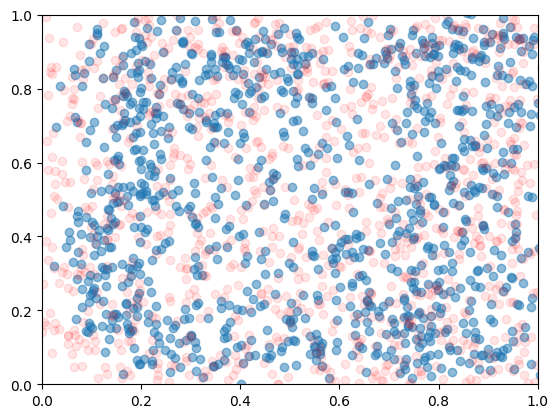

In [101]:
j = 6
plt.scatter(pred_xs,pred_ys, alpha = 0.5)
plt.scatter(train_xs, train_ys, c = 'red', alpha = 0.1)
plt.xlim(0, 1)
plt.ylim(0, 1)

In [94]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class VAE1(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, device=device):
        super(VAE1, self).__init__()

        # encoder - THIS CAN BE MESSED AROUND WITH
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim),
            )
        
        # latent mean and variance 
        self.mean_layer = nn.Linear(latent_dim, latent_dim)
        self.logvar_layer = nn.Linear(latent_dim, latent_dim)
        
        # decoder - THIS CAN ALSO BE MESSED AROUND WITH
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
            )
     
    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, logvar):
        epsilon = torch.randn_like(logvar).to(device)      
        z = mean + torch.exp(logvar/2.)*epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, logvar

In [95]:
# Initialize the VAE
input_dim = 2
hidden_dim = 32
latent_dim = 2
vae = VAE1(input_dim, hidden_dim, latent_dim)

# Define the loss function
def loss_function(recon_x, x, mu, logvar, alpha):
    # Reconstruction loss
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')

    # KL divergence loss
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + alpha*kl_loss

# Set up optimizer
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

# Convert your numpy data to PyTorch tensors
data = torch.tensor(np.random.rand(1000, 2), dtype=torch.float32)

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    # Forward pass
    recon_data, mu, logvar = vae(data)

    # Compute the loss
    loss = loss_function(recon_data, data, mu, logvar, 0.001)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print the loss for every few epochs
    if epoch % 10 == 0:
        print(f'Epoch {epoch}/{num_epochs}, Loss: {loss.item()}')


Epoch 0/1000, Loss: 662.3244018554688
Epoch 10/1000, Loss: 461.3025817871094
Epoch 20/1000, Loss: 330.38189697265625
Epoch 30/1000, Loss: 252.6764373779297
Epoch 40/1000, Loss: 233.68453979492188
Epoch 50/1000, Loss: 222.78518676757812
Epoch 60/1000, Loss: 206.41110229492188
Epoch 70/1000, Loss: 192.72509765625
Epoch 80/1000, Loss: 190.30746459960938
Epoch 90/1000, Loss: 172.08489990234375
Epoch 100/1000, Loss: 175.3295440673828
Epoch 110/1000, Loss: 166.4672088623047
Epoch 120/1000, Loss: 165.4585418701172
Epoch 130/1000, Loss: 158.82888793945312
Epoch 140/1000, Loss: 158.9676971435547
Epoch 150/1000, Loss: 157.48167419433594
Epoch 160/1000, Loss: 151.9762725830078
Epoch 170/1000, Loss: 148.07797241210938
Epoch 180/1000, Loss: 148.38467407226562
Epoch 190/1000, Loss: 144.40847778320312
Epoch 200/1000, Loss: 141.343017578125
Epoch 210/1000, Loss: 135.52806091308594
Epoch 220/1000, Loss: 134.6525115966797
Epoch 230/1000, Loss: 128.95716857910156
Epoch 240/1000, Loss: 126.1321792602539
E

In [96]:
preds = vae(data)[0]
pred_xs, pred_ys = preds[:,0].detach(), preds[:,1].detach()
train_xs, train_ys = data[:,0].detach(), data[:,1].detach()

(0.0, 1.0)

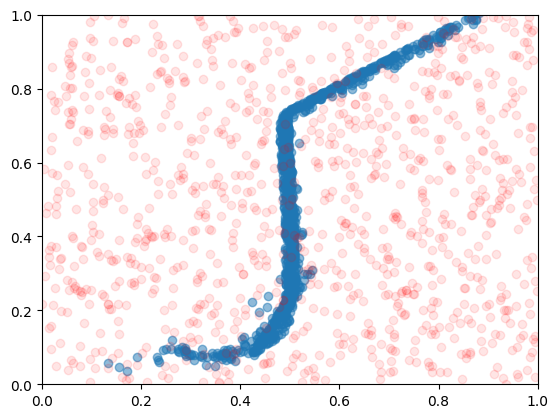

In [97]:
j = 6
plt.scatter(pred_xs,pred_ys, alpha = 0.5)
plt.scatter(train_xs, train_ys, c = 'red', alpha = 0.1)
plt.xlim(0, 1)
plt.ylim(0, 1)